#Loading raw data

In [26]:
immutable Halo
    x::Float32
    y::Float32
    z::Float32
    vx::Float32
    vy::Float32
    vz::Float32
    mvir::Float32
    m200b::Float32
    m200c::Float32
    m500c::Float32
    m2500c::Float32
    vmax::Float32
    rvmax::Float32
    r200b::Float32
    spin::Float32
    kin_to_pot::Float32
    id::Int64
    pid::Int64
end
m = Float64[]
x = Float64[]
y = Float64[]
z = Float64[]
vx = Float64[]
vy = Float64[]
vz = Float64[]
r = Float64[]
halos = Array(Halo, 10000000)
sz = stat("Dark_Sky_1600_Halos/ds.data").size
open("Dark_Sky_1600_Halos/ds.data", "r") do f
    # skip the header and sha1...
    seek(f, 1216 + (20+4)*64)
    
    while position(f) < sz-sizeof(halos)
        # read halos
        read!(f, halos)

        # filter
        ix = find(Float64[h.m200b for h in halos] .> 4.88e12)
        fh = halos[ix]
        ix = find(Float64[h.pid for h in fh] .< 0)
        fh = fh[ix]

        append!(m, Float64[h.m200b for h in fh])
        append!(x, Float64[h.x for h in fh])
        append!(y, Float64[h.y for h in fh])
        append!(z, Float64[h.z for h in fh])
        append!(vx, Float64[h.vx for h in fh])
        append!(vy, Float64[h.vy for h in fh])
        append!(vz, Float64[h.vz for h in fh])
        append!(r, Float64[h.r200b for h in fh]);
        println(position(f)/sz*100.0)
    end
    
    halos2 = Array(Halo, int((sz-position(f))/sizeof(Halo)))
    # read halos
    read!(f, halos2)

    # filter
    ix = find(Float64[h.m200b for h in halos2] .> 4.88e12)
    fh = halos2[ix]
    ix = find(Float64[h.pid for h in fh] .< 0)
    fh = fh[ix]

    append!(m, Float64[h.m200b for h in fh])
    append!(x, Float64[h.x for h in fh])
    append!(y, Float64[h.y for h in fh])
    append!(z, Float64[h.z for h in fh])
    append!(vx, Float64[h.vx for h in fh])
    append!(vy, Float64[h.vy for h in fh])
    append!(vz, Float64[h.vz for h in fh])
    append!(r, Float64[h.r200b for h in fh]);
end
halos=nothing
gc()

@show length(x)
@show minimum(x)
@show minimum(m)
@show maximum(x)
@show maximum(m)

3.647541822747575
7.295071097994443
10.942600373241312
14.590129648488178
18.237658923735047
21.88518819898192
25.532717474228782
29.180246749475653
32.827776024722525
36.47530529996939
40.12283457521626
43.77036385046313
47.417893125709995
51.06542240095686
54.71295167620374
58.3604809514506
62.008010226697465
65.65553950194433
69.3030687771912
72.95059805243808
76.59812732768494
80.24565660293182
83.89318587817868
87.54071515342554
91.18824442867242
94.83577370391927
98.48330297916615
length(x) => 4169709
minimum(x) => 0.0008643778273835778
minimum(m) => 4.880891117568e12
maximum(x) => 1599.99951171875
maximum(m) => 4.425567587794944e15


4.425567587794944e15

#Building a world

In [27]:
push!(LOAD_PATH,"./src/")
import nbody
reload("nbody")
nb = nbody;

In [28]:
particles = nb.Particle[nb.Particle(x[i]*1.e3, y[i]*1.e3, z[i]*1.e3, m[i]/1e10) for i in 1:length(x)];

In [29]:
Ol = 0.704874
Om = 0.295126
Ol+Om

1.0

In [30]:
length(particles)

4169709

In [31]:
w = nb.World(
        particles,
        5000.0,
        0.5,
        0.035,
        nb.Cosmological,
        Om,
        Ol);
for i in 1:w.n
    w.vx[i] = vx[i]
    w.vy[i] = vy[i]
    w.vz[i] = vz[i]
end

In [32]:
H=0.1
G=43007.1
rc = 3*H^2/8/π/G
@show pmass = 1600000^3*Om*rc/4096^3;

pmass = (1600000^3 * Om * rc) / 4096^3 => 0.4882348905251458


In [33]:
actual_mass = sum([p._m for p in particles])

9.174148144891535e9

In [34]:
required_mass = pmass*4096^3

3.3551246201146263e10

In [35]:
fac = required_mass/actual_mass

3.657151124143193

In [36]:
r = 200000.0
# filtering by location
nw = nb.filter_r(w, r);

smth = sqrt(w.smth2) => 5000.0
opening_alpha = sqrt(w.opening_alpha2) => 0.5
dtfrac = w.dtfrac => 0.035
space = typeof(w.space) => Cosmological
Ω0 = w.Ω0 => 0.295126
ΩΛ = w.ΩΛ => 0.704874


In [37]:
sum([p._m for p in nw.particles])*fac

2.8920479058782595e8

In [38]:
# scaling mass
H=0.1
G=43007.1
rc = 3*H^2/8/π/G
@show required_mass = 4/3*π*r^3*rc*Om

actual_mass = sum([p._m for p in nw.particles])
for i in 1:nw.n
    p = nw.particles[i]
    nw.particles[i] = nb.Particle(p._x,p._y,p._z, p._m*required_mass/actual_mass)
end
nb.save(nw, "w.data")

required_mass = (4 / 3) * π * r^3 * rc * Om => 2.7449049110495716e8


In [39]:
nw.n

35283

In [40]:
sum([p._m for p in nw.particles])

2.7449049110495716e8

In [41]:
using Winston

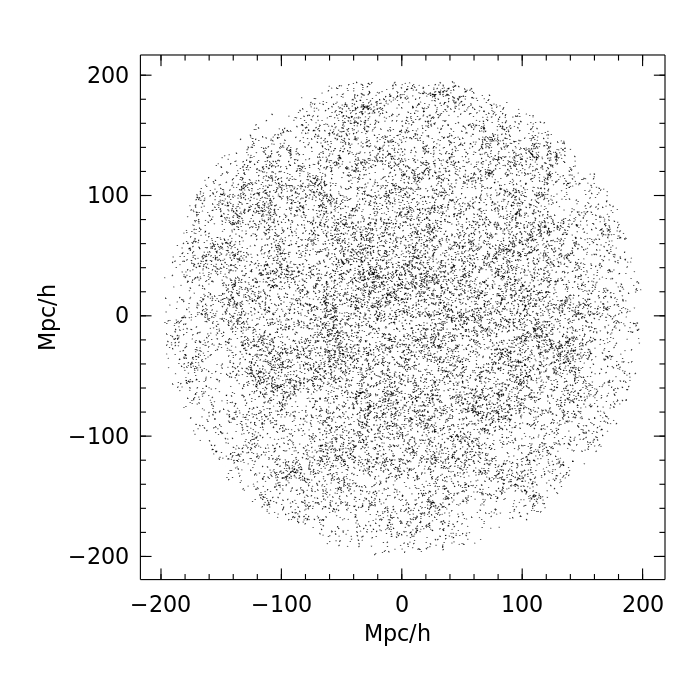

In [42]:
hold(false)
nb.plot(nw)

In [43]:
nb.save(nw, "BYHALO_200KPC.DATA")

#Optimizing!

In [1]:
using Winston

In [2]:
workers()

1-element Array{Int64,1}:
 1

In [3]:
addprocs(8)

8-element Array{Any,1}:
 2
 3
 4
 5
 6
 7
 8
 9

In [4]:
workers()

8-element Array{Int64,1}:
 2
 3
 4
 5
 6
 7
 8
 9

In [1]:
1/51

0.0196078431372549

In [5]:
@everywhere begin
    push!(LOAD_PATH,"./src/")
    import nbody
    reload("nbody")
    nb = nbody;
end

In [6]:
w = nb.load_w("BYHALO.DATA");

In [7]:
#sim = nb.Simulation(deepcopy(w), limit_by_steps=false, stepc=1, ti=0.0196078431372549, tf=1.0, n_test_particle=3*w.n);
sim = nb.Simulation(deepcopy(w), limit_by_steps=false, stepc=1, ti=0.05, tf=1.0, n_test_particle=3*w.n);
sim.w.smth2 = 8500.0^2

7.225e7

In [8]:
opt = nb.Optimization(sim);

In [8]:
opt.sim = nb.load_sim("sim.data");

LoadError: opt not defined
while loading In[8], in expression starting on line 1

In [9]:
(100000^3/5200)^(1/3)

5772.078366321594

 grade=511184.2302072217 n=3963


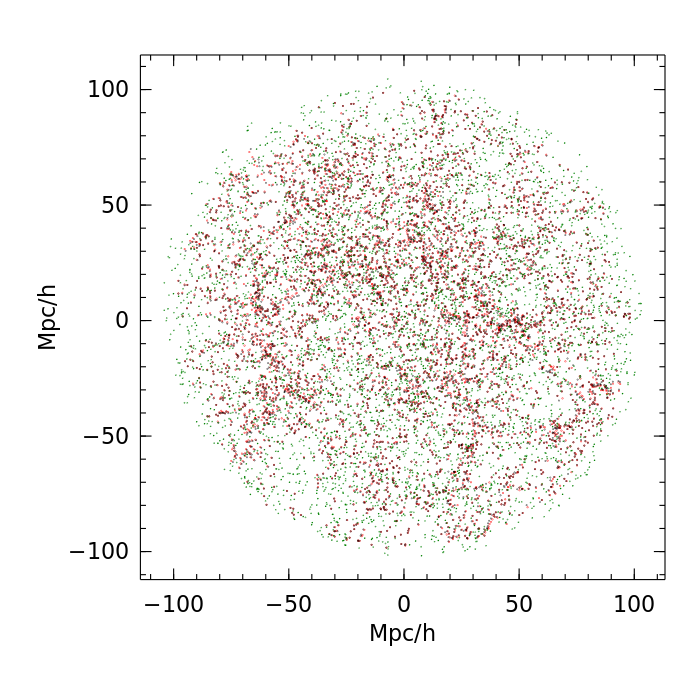

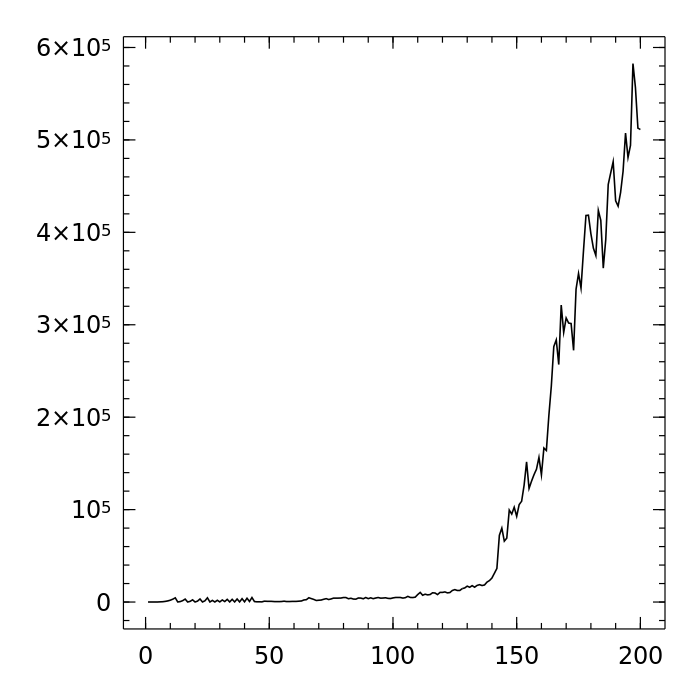

maximum(opt.grad) => 4.316770079081937e7
g=511184.2302072217


In [10]:
step=0
N=500
ga = Float64[]
Winston.set_default_plot_size(700,700)
import IJulia
#for l_target_t in linspace(log(opt.sim.tf*0.99), log(opt.sim.ti), N)
for l_target_t in linspace(log(opt.sim.tf*0.999), log(0.1), 200)    
    step+=1
    target_t = exp(l_target_t)
    
    println("----------------------- ti=",target_t," comp: ",step/N*100)
    opt.sim.ti = target_t
    g=nb.optimize(opt, 5, 5000.0)
    send_ipython(IJulia.publish, msg_pub(IJulia.execute_msg, "clear_output", [:wait => true]))
    #? nb.exec!(sim, false, silent=true)
    display(nb.plot(opt))
    push!(ga, g/1.0)
    display(Winston.plot([1:length(ga)], ga))
    
    #pp = FramedPlot()
    #add(pp, Histogram(hist(opt.grad[opt.grad.>1000])...))    
    #display(pp)
    println("==============================================")
    @show maximum(opt.grad)
    println("g=",g/1.0)
    #if g/1000000.0>1.0
    #    break
    #end
    #break
end

In [12]:
nb.save(opt.sim, "sim.data")

In [1]:
nb.plot(opt)

LoadError: nb not defined
while loading In[1], in expression starting on line 1

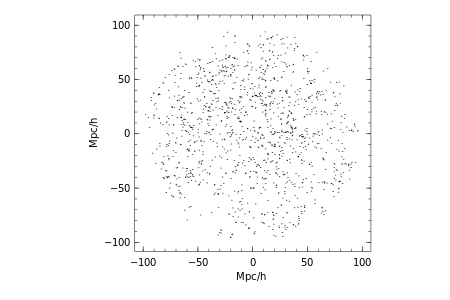

In [37]:
nb.plot(w)

In [2]:
sim = nb.load_sim("sim.data")
w = nb.load_w("w.data");

tn => 15534


In [3]:
@show w.n
@show sim.w.n

w.n => 5170
sim.w.n => 5178


5178

#Analyzing

In [31]:
using Winston
Winston.set_default_plot_size(700,700)
@everywhere begin
    push!(LOAD_PATH,"./src/")
    import nbody
    reload("nbody")
    nb = nbody;
end

In [80]:
sim = nb.load_sim("3000_full_zeld_200kpc/out16.sim")
#sim = nb.load_sim("1700_full_zeld_150kpc/out10.sim")
#sim = nb.load_sim("1700_no_zeld/out19.sim")
#sim = nb.load_sim("1700_full_zeld/out11.sim")
#sim = nb.load_sim("6500_full_zeld/out13.sim")
w = nb.load_w("BYHALO_200KPC.DATA")
#w = nb.load_w("BYHALO_150KPC.DATA")
#w = nb.load_w("BYHALO.DATA")
@show sim.w.n
@show sim.ti
@show w.n
@show w.vx[1]

tn => 105849
sim.w.n => 35283
sim.ti => 0.5366425822825762
w.n => 35283
w.vx[1] => -137.9784013832022


-137.9784013832022

In [64]:
1/sim.ti-1

0.8634376641275121

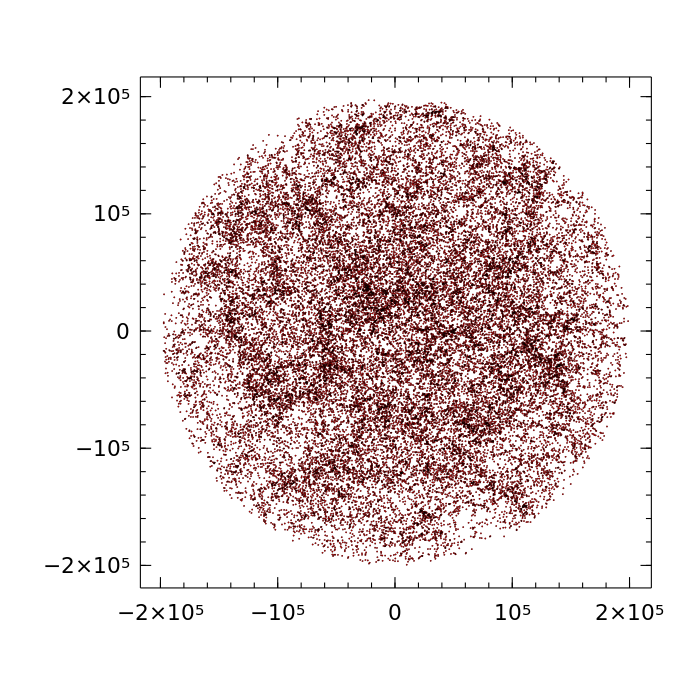

In [59]:
nb.plot(sim.w, w)

In [73]:
sqrt(w.smth2)

5000.0

In [81]:
w.smth2 = 1.0^2

1.0

In [82]:
nb.calc_accel!(w, 1:w.n);

In [83]:
for i in 1:w.n
    sim.w.vx[i] = w.ax[i]
end

In [84]:
function getv(w::nb.World, nw::nb.World, thr=50000.0)
    vx = zeros(w.n)
    m = zeros(w.n)
    R = zeros(w.n)
    for n in 1:w.n
        v::Float64 = 0.0
        pn = nw.particles[n]
        r2 = pn._x^2+pn._y^2+pn._z^2
        r2 > thr*thr && continue
        RSMTH::Float64 = 15000.0
        mass::Float64 = 0.0
        while true
            vx[n] = 0.0
            mass = 0.0
            v = 0.0
            for i in 1:w.n
                pi = w.particles[i]

                dx = pi._x - pn._x
                dy = pi._y - pn._y
                dz = pi._z - pn._z
                d2 = dx*dx+dy*dy+dz*dz

                if d2 < RSMTH*RSMTH
                    mass += 1.0#pi._m
                    v += w.vx[i]*1.0#pi._m
                end

            end
            mass > 0.01 && break
            RSMTH *= 1.2
        end
        vx[n] = v/mass
        m[n] = mass
        R[n] = RSMTH
    end
    ix = find(m.>0.1)
    vx, m, R, ix
end
nvx, m, R, ix = getv(sim.w, w, 100000)
vx, m0, R0, ix0 = getv(w, w, 100000)
nvx = nvx[ix]
vx = vx[ix];

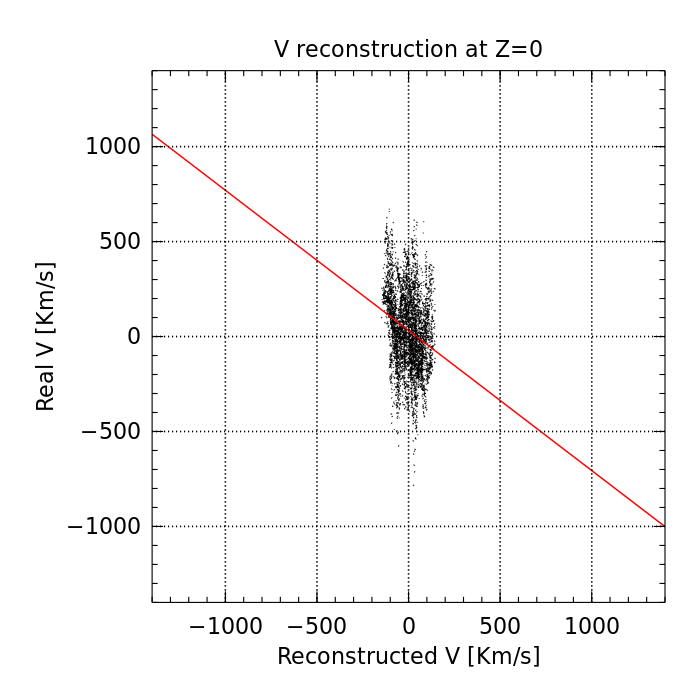

In [85]:
hold(false)
scatter(nvx, vx, 0.0002)#, aspect_ratio=1.0)
#ix = find([p._x^2+p._y^2+p._z^2 for p in w.particles] .< 150000^2)
#scatter(sim.w.vx, w.vx, 0.001, aspect_ratio=1.0)
hold(true)
b,a = linreg(nvx, vx)
#b,a = linreg(sim.w.vx.s, w.vx.s, Float64[p._m for p in w.particles])
x = [-1400,1400]
y = b+a*x
plot(x,y,"red")
grid(true)
xlabel("Reconstructed V [Km/s]")
ylabel("Real V [Km/s]")
title("V reconstruction at Z=0")
xlim(-1400,1400)
ylim(-1400,1400)

In [86]:
cor(nvx, vx)

-0.24802197839567555

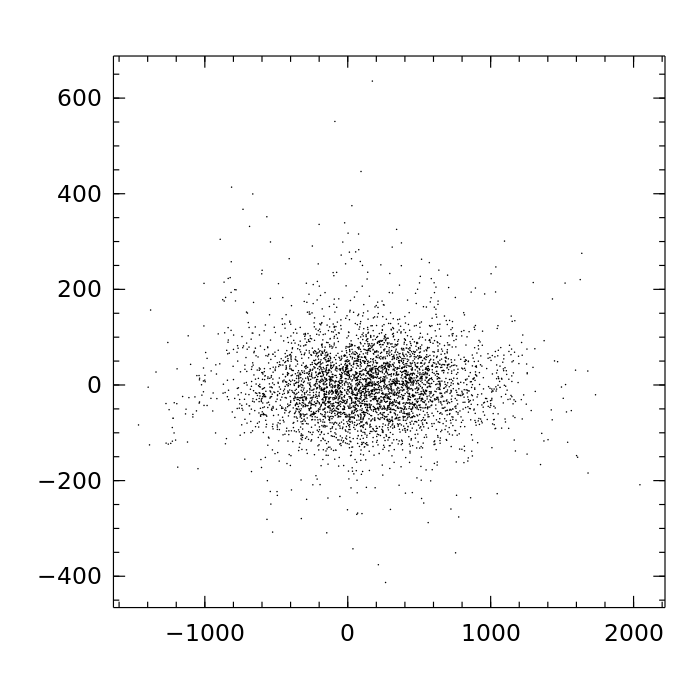

In [70]:
x = deepcopy(nvx);
y = deepcopy(vx).-b.-a.*x
hold(false)
scatter(x,y,0.001,aspect_ratio=1.0)

In [71]:
std(y)

78.49709356804024

In [68]:
vx

23944-element Array{Float64,1}:
 -304.945 
 -406.872 
 -294.127 
 -415.174 
 -415.174 
 -239.139 
 -281.724 
   23.2988
 -104.08  
 -104.08  
 -173.02  
  -44.3631
 -156.478 
    ⋮     
   95.1927
  100.217 
   66.5114
 -387.024 
 -387.024 
 -302.615 
 -190.3   
 -203.212 
 -255.816 
 -253.408 
 -253.408 
  -55.5696

In [152]:
linreg(nvx, vx, Float64[p._m for p in w.particles])[2]

0.5932123734926529

In [64]:
cor(sim.w.vx.s, w.vx.s)

0.8567089888016851

In [111]:
ix = find(!isnan(vx) .* !isnan(nvx));

In [75]:
x=randn(100)
y=2x+7
cor(x,y)

0.9999999999999998

tn => 105849
tn => 105849
tn => 105849
tn => 105849
tn => 105849
tn => 105849
tn => 105849
tn => 105849
tn => 105849
tn => 105849
tn => 105849
tn => 105849
tn => 105849
tn => 105849
tn => 105849
tn => 105849
tn => 105849
tn => 105849
tn => 105849
tn => 105849
tn => 105849
tn => 105849
tn => 105849
tn => 105849
tn => 105849
tn => 105849
tn => 105849
tn => 105849
tn => 105849
tn => 105849
tn => 105849
tn => 105849
tn => 105849
tn => 105849
tn => 105849
tn => 105849
tn => 105849
tn => 105849
tn => 105849
tn => 105849
tn => 105849
tn => 105849
tn => 105849
tn => 105849
tn => 105849
tn => 105849
tn => 105849
tn => 105849


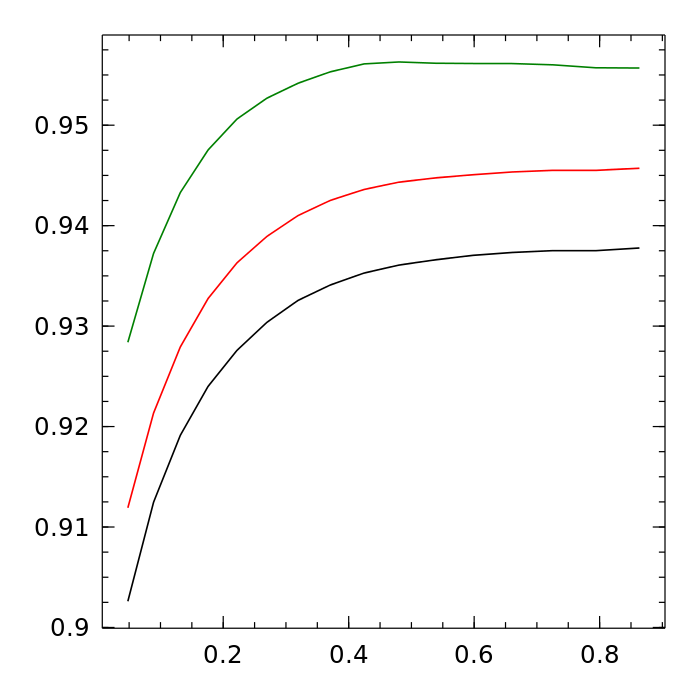

In [57]:
b17 = Float64[]
z17 = Float64[]
for i in 1:16
    sim = nb.load_sim("3000_full_zeld_200kpc/out"*string(i)*".sim")
    w = nb.load_w("BYHALO_200KPC.DATA")
    nvx, m, R, ix = getv(sim.w, w, 100000.0)
    vx, m, R, ix0 = getv(w, w, 100000.0)
    push!(b17, cor(vx[ix], nvx[ix]))
    #push!(b17, linreg(nvx, vx)[2])
    #push!(b, linreg(sim.w.vx.s, w.vx.s)[2])
    push!(z17, 1./sim.ti-1)
end
b65 = Float64[]
z65 = Float64[]
for i in 1:16
    sim = nb.load_sim("3000_full_zeld_200kpc/out"*string(i)*".sim")
    w = nb.load_w("BYHALO_200KPC.DATA")
    nvx, m, R, ix = getv(sim.w, w, 150000)
    vx, m, R, ix0 = getv(w, w, 150000)
    push!(b65, cor(vx[ix], nvx[ix]))
    #push!(b65, linreg(nvx, vx)[2])
    #push!(b, linreg(sim.w.vx.s, w.vx.s)[2])
    push!(z65, 1./sim.ti-1)
end
b98 = Float64[]
z98 = Float64[]
for i in 1:16
    sim = nb.load_sim("3000_full_zeld_200kpc/out"*string(i)*".sim")
    w = nb.load_w("BYHALO_200KPC.DATA")
    nvx, m, R, ix = getv(sim.w, w, 175000.0)
    vx, m, R, ix = getv(w, w, 175000.0)
    push!(b98, cor(vx[ix], nvx[ix]))
    #push!(b65, linreg(nvx, vx)[2])
    #push!(b, linreg(sim.w.vx.s, w.vx.s)[2])
    push!(z98, 1./sim.ti-1)
end
hold(false)
plot(z17,b17,"green")
hold(true)
plot(z65,b65,"red")
plot(z98,b98,"black")

In [4]:
b17

9-element Array{Float64,1}:
 0.847673
 0.851226
 0.856102
 0.861598
 0.867178
 0.872697
 0.877943
 0.882801
 0.887241

In [100]:
b65

23-element Array{Float64,1}:
 0.684467
 0.690796
 0.688676
 0.682478
 0.674773
 0.666778
 0.658871
 0.651187
 0.64409 
 0.637587
 0.631802
 0.626356
 0.621167
 0.616684
 0.61259 
 0.608848
 0.605533
 0.602662
 0.599722
 0.597471
 0.59539 
 0.593294
 0.591566